## The goal is to use our new dataset (that might be corrupted intergrally in neg lons whatever) by build a representation of extremes precip compared to systems vavg

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import random 
import os 

from work import handler
from work import casestudy
from work import storm_tracker

from work.plots.hist import simple_hist
from work.thermo import haversine 

settings_path = 'settings/sam3d.yaml'
# Instantiate CaseStudy by passing the settings. 
# Should also create appropriate directories
hdlr = handler.Handler(settings_path)
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)
st = storm_tracker.StormTracker(cs, overwrite_storms = False, overwrite = False, verbose = True) #overwrite = True is super long, computes growth rate (triangle fit)

In [57]:
duration_min = 10
surfmaxkm2_min = 50000
region_latmin, region_latmax, region_lonmin, region_lonmax = -15, 30, -180, 180
filename_save = f"updated_storms_dmin{duration_min}_smin{surfmaxkm2_min}_lat{region_latmin}_{region_latmax}_lon{region_lonmin}_{region_lonmax}.nc"
storms_path = os.path.join(os.path.join(st.settings["DIR_DATA_OUT"], cs.name), filename_save)
ft = xr.open_dataset(storms_path)
storms = xr.open_dataset(st.file_storms)

In [30]:
def filter_storm(ft, region_lonmin, region_lonmax, region_latmin, region_latmax, vavg_min=None, vavg_max=None,):
    if vavg_max is None and vavg_min is None : 
        pass
    elif vavg_max is None :
        ft =  ft.where(ft.INT_velocityAvg > vavg_min, drop=True)
    elif vavg_min is None :
        ft = ft.where(ft.INT_velocityAvg < vavg_max, drop=True)
    elif vavg_min is not None and vavg_max is not None : 
        print("you don't understand what you're doing my dear")
    # Apply latitude and longitude constraints
    ft = ft.where((ft.INT_latmin >= region_latmin) & (ft.INT_latmax <= region_latmax), drop=True)
    if region_lonmin>=0 : 
        ft = ft.where((ft.INT_lonmin >= region_lonmin) & (ft.INT_lonmax <= region_lonmax), drop=True)
    elif region_lonmin<0:
        ft = ft.where((ft.INT_lonmin >= 360+region_lonmin) | (ft.INT_lonmin <= region_lonmax), drop=True)
    return ft

def merge_missing_vars(ft, storms):
    variables_to_add = set(storms.data_vars) - set(ft.data_vars)
    storms_new_vars = storms[variables_to_add]
    storms_new_vars_filtered = storms_new_vars.sel(DCS_number=ft.DCS_number)
    ft_updated = xr.merge([ft, storms_new_vars_filtered])
    return ft_updated

In [69]:
ft["INT_max_accumulated_90"] = np.max(ft.LC_accumulated_prec_90th, axis=1)
ft["INT_max_instant_90"] = np.max(ft.LC_instant_prec_90th, axis=1)
ft["INT_sum_total"] = np.sum(ft.LC_total_prec, axis=1)

ft = ft.dropna(dim='DCS_number', subset=['INT_velocityAvg', 'INT_sum_total', 'INT_max_instant_90', 'INT_max_accumulated_90'])

ft_updated = merge_missing_vars(ft, storms)
fft = filter_storm(ft_updated,  region_lonmin, region_lonmax, region_latmin, region_latmax, vavg_max = 2.2) #vavg_min =7.4  , vavg_max = 2.2

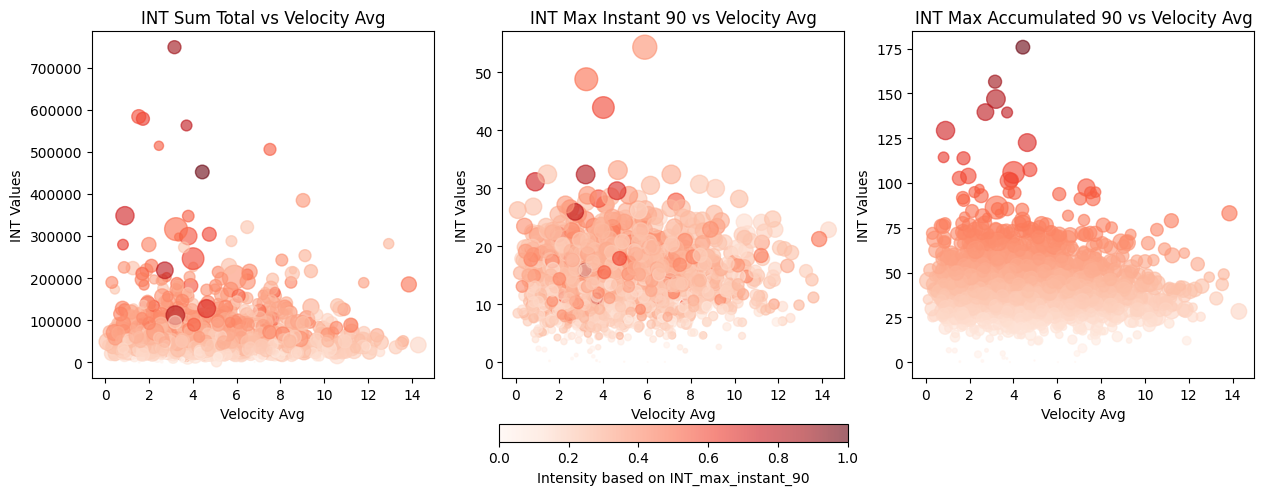

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig, axs = plt.subplots(1, 3, figsize=(15, 6))

# Define data pairs and labels
data_pairs = [
    (ft['INT_velocityAvg'], ft['INT_sum_total'], "INT Sum Total vs Velocity Avg"),
    (ft['INT_velocityAvg'], ft['INT_max_instant_90'], "INT Max Instant 90 vs Velocity Avg"),
    (ft['INT_velocityAvg'], ft['INT_max_accumulated_90'], "INT Max Accumulated 90 vs Velocity Avg")
]

# Scale point size based on INT_max_accumulated_90 and color based on INT_max_instant_90
sizes =ft['INT_max_instant_90'] / ft['INT_max_instant_90'].max() *100
colors =  ft['INT_max_accumulated_90'] / ft['INT_max_accumulated_90'].max()

for ax, (x_data, y_data, title) in zip(axs, data_pairs):
    scatter = ax.scatter(x_data, y_data, s=3*sizes, c=colors, cmap='Reds', alpha=0.6)
    ax.set_ylabel("INT Values")
    ax.set_xlabel("Velocity Avg")
    ax.set_title(title)

# Add color bar to reflect intensity of red based on INT_max_instant_90
cbar = fig.colorbar(scatter, ax=axs.ravel().tolist(),  shrink=0.3, orientation='horizontal', pad=0.1)
cbar.set_label('Intensity based on INT_max_instant_90')

# plt.tight_layout()
plt.show()


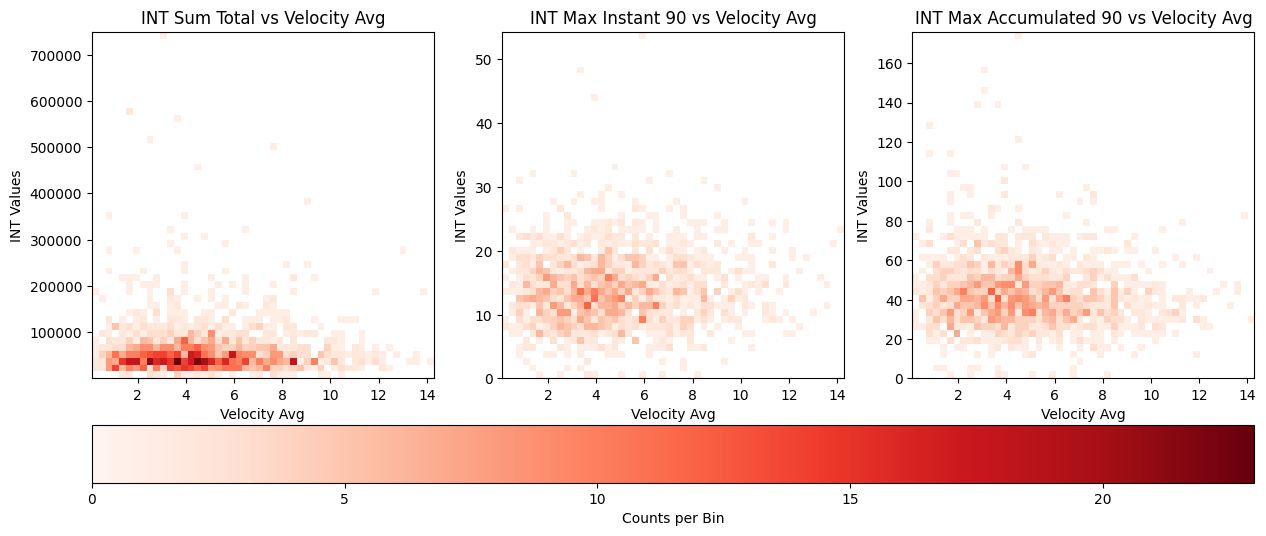

In [73]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

# Define data pairs and labels
data_pairs = [
    (ft['INT_velocityAvg'], ft['INT_sum_total'], "INT Sum Total vs Velocity Avg"),
    (ft['INT_velocityAvg'], ft['INT_max_instant_90'], "INT Max Instant 90 vs Velocity Avg"),
    (ft['INT_velocityAvg'], ft['INT_max_accumulated_90'], "INT Max Accumulated 90 vs Velocity Avg")
]

# Set the number of bins for the histograms
x_bins = 50
y_bins = 50

# Collect all the histogram plots to adjust color scales and add a color bar
histograms = []

# First, find the global maximum count to normalize the color scale across all subplots
max_count = 0
for x_data, y_data, _ in data_pairs:
    counts, _, _ = np.histogram2d(x_data, y_data, bins=[x_bins, y_bins])
    max_count = max(max_count, counts.max())

# Now, create the 2D histograms with consistent color scaling
for ax, (x_data, y_data, title) in zip(axs, data_pairs):
    h = ax.hist2d(
        x_data,
        y_data,
        bins=[x_bins, y_bins],
        cmap='Reds',
        cmin=1,
        vmin=0,
        vmax=max_count
    )
    ax.set_ylabel("INT Values")
    ax.set_xlabel("Velocity Avg")
    ax.set_title(title)
    histograms.append(h[3])  # h[3] is the QuadMesh artist

# Add a shared color bar for all subplots
cbar = fig.colorbar(
    histograms[0],
    ax=axs.ravel().tolist(),
    orientation='horizontal',
    pad=0.1
)
cbar.set_label('Counts per Bin')

# plt.tight_layout()
plt.show()


In [64]:
y_data

<xarray.DataArray 'INT_max_instant_90' (DCS_number: 1629)>
array([        nan,         nan,         nan, ..., 11.0586792 ,
       16.21361084,  1.00758057])
Coordinates:
  * DCS_number  (DCS_number) int64 153377 153378 153381 ... 287202 288002 290191